# Spotify Song Popularity Analysis - Practice Assignment

## Overview
This notebook demonstrates the process of analyzing Spotify song features to predict song popularity using machine learning. This is a practice assignment to showcase data science workflow and documentation.

## Steps We'll Follow:
1. **Setup and Data Loading**
   - Import required libraries
   - Load and examine the dataset

2. **Data Preprocessing**
   - Clean the data
   - Engineer new features
   - Transform categorical variables

3. **Model Development**
   - Split data into training and testing sets
   - Scale features
   - Train and optimize model

4. **Evaluation and Visualization**
   - Assess model performance
   - Create visualizations
   - Document insights

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True

## Step 1: Data Loading and Initial Exploration

We'll start by loading the Spotify dataset and examining its structure.

In [3]:
# Load the dataset
df = pd.read_csv('../Untitled/Resources/spotify_songs.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
df.head()

Dataset Shape: (32833, 23)

Columns: ['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

Sample of the data:


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


## Step 2: Data Preprocessing and Feature Engineering

We'll prepare our data by:
1. Creating popularity categories
2. Engineering new features
3. Handling categorical variables

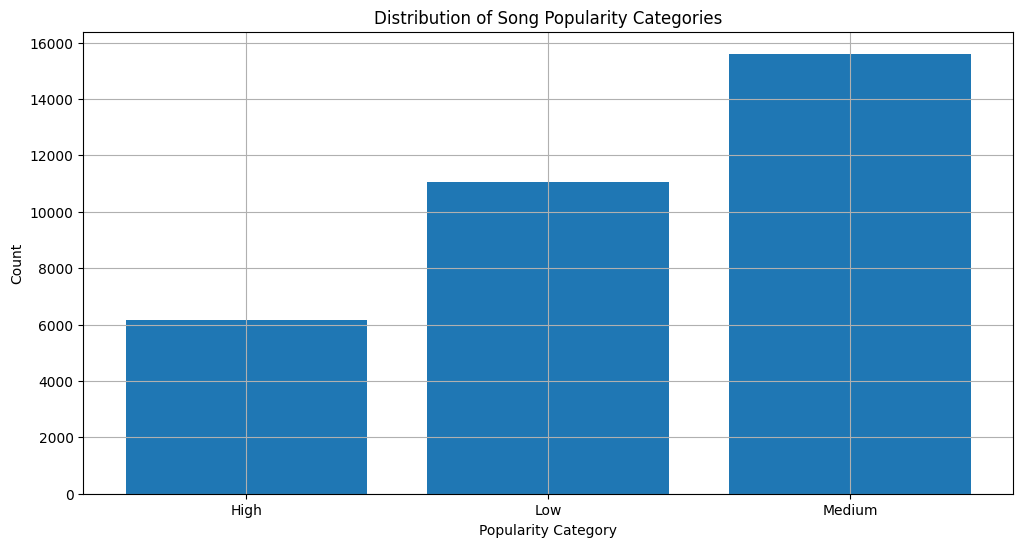

In [4]:
# Create popularity categories
def categorize_popularity(x):
    if x >= 67:  # Top 25%
        return 'High'
    elif x >= 34:  # Middle 50%
        return 'Medium'
    else:  # Bottom 25%
        return 'Low'

df['popularity_category'] = df['track_popularity'].apply(categorize_popularity)

# Feature engineering
df['energy_danceability'] = df['energy'] * df['danceability']
df['loudness_scaled'] = (df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
df['tempo_scaled'] = df['tempo'] / df['tempo'].max()

# One-hot encode genre
genre_dummies = pd.get_dummies(df['playlist_genre'], prefix='genre')
df = pd.concat([df, genre_dummies], axis=1)

# Visualize popularity distribution
plt.figure()
popularity_counts = df['popularity_category'].value_counts().sort_index()
plt.bar(popularity_counts.index, popularity_counts.values)
plt.title('Distribution of Song Popularity Categories')
plt.xlabel('Popularity Category')
plt.ylabel('Count')
plt.show()

## Step 3: Model Development

Now we'll prepare our features and train the model.

In [5]:
# Select features for prediction
audio_features = [
    'danceability', 'energy', 'key', 'loudness_scaled', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo_scaled', 'energy_danceability'
]

genre_columns = [col for col in df.columns if col.startswith('genre_')]
features = audio_features + genre_columns

# Prepare X (features) and y (target)
X = df[features]
y = df['popularity_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (26266, 17)
Testing set shape: (6567, 17)


## Step 4: Model Training and Optimization

In [6]:
# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and train model with GridSearch
rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_model.fit(X_train_scaled, y_train)

print("Best parameters:", rf_model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/cjmacstudio/Desktop/CU-VIRT-AI-PT-09-2024-U-LOLC/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Step 5: Model Evaluation

In [7]:
# Make predictions with best model
best_model = rf_model.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy Score: {accuracy:.2f}")
print("\nClassification Report:")
print(class_report)

Accuracy Score: 0.59

Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.48      0.58      1234
         Low       0.58      0.33      0.43      2212
      Medium       0.57      0.82      0.67      3121

    accuracy                           0.59      6567
   macro avg       0.63      0.54      0.56      6567
weighted avg       0.60      0.59      0.57      6567



## Step 6: Results Visualization

In [7]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1, 2], ['High', 'Low', 'Medium'])
plt.yticks([0, 1, 2], ['High', 'Low', 'Medium'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add text annotations
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(conf_matrix[i, j]),
                 ha='center', va='center')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(range(15), feature_importance['importance'][:15])
plt.xticks(range(15), feature_importance['feature'][:15], rotation=45, ha='right')
plt.title('Top 15 Features for Predicting Song Popularity')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

NameError: name 'conf_matrix' is not defined

<Figure size 1000x800 with 0 Axes>

## Step 7: Save Results

In [ ]:
# Create output directory
output_dir = 'analysis_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save feature importance
feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
predictions_df.to_csv(os.path.join(output_dir, 'predictions.csv'), index=False)

# Save model performance metrics
with open(os.path.join(output_dir, 'model_performance.txt'), 'w') as f:
    f.write(f"Best Parameters: {rf_model.best_params_}\n")
    f.write(f"Accuracy Score: {accuracy:.2f}\n")
    f.write("\nClassification Report:\n")
    f.write(class_report)

print("Results saved to", output_dir)